# Artificial Neural Network for stable points

## Import libraries and preprocessing

In [1]:
# read & manipulate data
import keras_tuner as kt
import pandas as pd 
import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# visualisations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

plt.style.use('fivethirtyeight') #plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['figure.facecolor'] = 'white'  # For the figure background
plt.rcParams['axes.facecolor'] = 'white'    # For the axes background
plt.rcParams['axes.edgecolor'] = 'white'    # Set the axes edge color to white
plt.rcParams['savefig.facecolor'] = 'white' # For the figure background when saving
pd.set_option('display.max_columns', None)

# load the dataset
import sys
sys.path.append("../scripts")

# misc
import random as rn
import utils
import warnings

# setting random seeds for libraries to ensure reproducibility
RANDOM_SEED = 420
TRAINING_SAMPLE = 15000
VALIDATE_SIZE = 0.2

np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [22]:
# Model paths
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
tuner_path = '/Users/junxingli/Desktop/master_thesis/models/ann/'
proj_name = 'stationary-whole-V3/'
best_model_path = tuner_path + proj_name + 'best_model'

# Figure paths
overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/ann/'
plots_path = figs_path + proj_name

In [23]:
df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")
df = df[df['Status'] == 'Stable']

#X = df.drop(['Status', 'SRD', 'A11', 'B11', 'A12', 'B12', 'Cap', 'L7'], axis=1)
X = df.drop(['Status', 'SRD', 'T5'], axis=1)
y = df[['Time', 'SRD']]

date = "2020-06-15 00:00"
X_train = X[X["Time"] < date].copy()
X_test = X[X["Time"] > date].copy()
y_train = y[y["Time"] < date].copy()
y_test = y[y["Time"] > date].copy()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standard scaling the data
scaler = StandardScaler()
cols = [col for col in X_train.columns if col != 'Time']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Need to reshape since the scaler expects a 2D array
y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

input_dim = X.drop('Time', axis=1).shape[1]
output_dim = y.drop('Time', axis=1).shape[1]

In [24]:
def plot_results(df_res):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Actual"], 
            mode='markers', 
            marker=dict(size=4),
            name='Actual',
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Predicted"], 
            mode='markers', 
            marker=dict(size=4),
            name='Prediction',
        )
    )

    fig.update_layout(title="Modelling the SRD using ANN", 
                    legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.3
                        ),
                    template="seaborn",
                    xaxis_title="Time", 
                    yaxis_title="Specific Reboiler Duty [MJ/kgCO2]")

    fig.show()

def prediction_df(model, scaler, X, y):
    y_pred = model.predict(X.drop('Time', axis=1))
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))

    df_res = pd.DataFrame({'Time': y_inv['Time'], 
                           'Actual': y_inv['SRD'], 
                           'Predicted': y_pred.flatten()})
    df_res.sort_values('Time')
    
    rmse = mean_squared_error(df_res['Actual'], df_res['Predicted'], squared=False)
    r2 = r2_score(df_res['Actual'], df_res['Predicted'])
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 Score: {r2}")
    
    return df_res, rmse

## Simple ANN with zero hidden layers

In [ ]:
def buildModel(optimizer='adam'):
    classifier = Sequential()

    classifier.add(Input(shape=(input_dim,)))    
    #classifier.add(Dense(units=128, activation='relu'))
    #classifier.add(Dense(units=128, activation='relu'))
    classifier.add(Dense(units=1, activation='linear'))
    
    classifier.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])
    
    return classifier

regressor = buildModel('adam')
History = regressor.fit(x=X_train.drop('Time', axis=1), 
                        y=y_train.drop('Time', axis=1),
                        batch_size=32, 
                        epochs=100, 
                        verbose=0)

In [ ]:
first_layer_weights = regressor.layers[0].get_weights()[0]

df = pd.DataFrame({'Feature': X.drop('Time', axis=1).columns,
                   'Coefficient': first_layer_weights.flatten()})

fig = go.Figure(data=[go.Bar(x=df['Feature'], y=df['Coefficient'])])  

fig.update_layout(
                xaxis_title="Feature",
                yaxis_title="Coefficient",
                height=400,
                width=800,
                legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.15
                        ),
                template="seaborn",
                margin=dict(l=0, r=20, t=20, b=10),
                )

In [ ]:
plt.plot(History.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
def plot_results(df_res):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Actual"], 
            mode='markers', 
            marker=dict(size=4),
            name='Actual',
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Predicted"], 
            mode='markers', 
            marker=dict(size=4),
            name='Prediction',
        )
    )

    fig.update_layout(title="Modelling the SRD using ANN", 
                    legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.3
                        ),
                    template="seaborn",
                    xaxis_title="Time", 
                    yaxis_title="Specific Reboiler Duty [MJ/kgCO2]")

    fig.show()

def prediction_df(model, scaler, X, y):
    y_pred = model.predict(X.drop('Time', axis=1))
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))

    df_res = pd.DataFrame({'Time': y_inv['Time'], 
                           'Actual': y_inv['SRD'], 
                           'Predicted': y_pred.flatten()})
    df_res.sort_values('Time')
    
    rmse = mean_squared_error(df_res['Actual'], df_res['Predicted'], squared=False)
    print(f"Root Mean Squared Error: {rmse}")
    
    return df_res

In [ ]:
df_train = prediction_df(regressor, scaler, X_train, y_train)
df_test = prediction_df(regressor, scaler, X_test, y_test)
#plot_results(df_res)

# Using Keras Tuner

WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

In [36]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp): 
        hp_layers = hp.Int('num_layers', 3, 5)
        #hp_normal = hp.Boolean('normalization', default=False)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
            
        model = keras.Sequential()
        model.add(Input(shape=(input_dim,)))
        for i in range(hp_layers):
            hp_nodes = hp.Int('num_nodes_'+str(i), min_value=50, max_value=150, step=5)
            hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
            hp_dropout = hp.Boolean('dropout-normalization', default=False)
            
            model.add(Dense(units=hp_nodes, activation=hp_activation))
            if hp_dropout:
                model.add(Dropout(rate=0.25))
                model.add(BatchNormalization())
        
        model.add(Dense(1, activation='linear'))
        
        # Select optimizer    
        optimizer_dict = {
            'adam': keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
            'SGD': keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
            'rmsprop': keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate)
        }
        model.compile(
            optimizer=optimizer_dict[hp_optimizer],
            loss='mean_squared_error',
            metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [37]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_mean_squared_error',
    max_epochs=2000,
    overwrite=False,
    directory=tuner_path,
    project_name=proj_name)

reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='val_mean_squared_error', 
                                              patience=50)

tuner.search(X_train.drop('Time', axis=1),
             y_train.drop('Time', axis=1), 
             epochs=2000, 
             validation_split=0.25, 
             callbacks=[stop_early])
             #callbacks=[stop_early, reduce_lr])

Trial 1950 Complete [00h 00m 18s]
val_mean_squared_error: 0.5621756315231323

Best val_mean_squared_error So Far: 0.49358609318733215
Total elapsed time: 04h 23m 12s


In [40]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

History = best_model.fit(X_train.drop('Time', axis=1), 
                         y_train.drop('Time', axis=1), 
                         epochs=2000, 
                         callbacks=[tf.keras.callbacks.EarlyStopping(
                                    monitor='mean_squared_error', 
                                    patience=100)
                                    ],
                         validation_split=0)

best_model.save(best_model_path)

best_model.summary()
print(f"""{best_hps.values}
-------------------------------------
Model saved to {best_model_path}""")

Epoch 1/2000
313/313 [==============================] - 1s 679us/step - loss: 0.2257 - mean_squared_error: 0.2257 - mean_absolute_error: 0.2960 - mean_absolute_percentage_error: 259.1738
Epoch 2/2000
313/313 [==============================] - 0s 667us/step - loss: 0.2117 - mean_squared_error: 0.2117 - mean_absolute_error: 0.2818 - mean_absolute_percentage_error: 303.3169
Epoch 3/2000
313/313 [==============================] - 0s 662us/step - loss: 0.2076 - mean_squared_error: 0.2076 - mean_absolute_error: 0.2761 - mean_absolute_percentage_error: 276.6346
Epoch 4/2000
313/313 [==============================] - 0s 1ms/step - loss: 0.2018 - mean_squared_error: 0.2018 - mean_absolute_error: 0.2699 - mean_absolute_percentage_error: 243.3029
Epoch 5/2000
313/313 [==============================] - 0s 844us/step - loss: 0.1975 - mean_squared_error: 0.1975 - mean_absolute_error: 0.2661 - mean_absolute_percentage_error: 250.4283
Epoch 6/2000
313/313 [==============================] - 0s 683us/st

File Loss_over_epoch.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Loss_over_epoch.pdf.


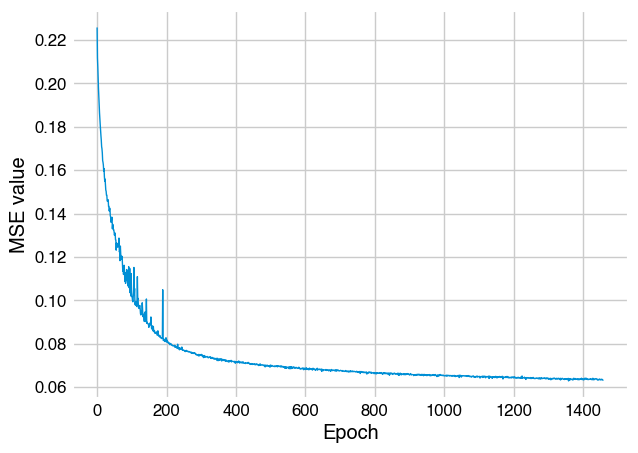

In [42]:
plt.plot(History.history['mean_squared_error'], linewidth=1)
plt.ylabel('MSE value')
plt.xlabel('Epoch')

utils.save_file(plt.gcf(), plots_path, "Loss_over_epoch.pdf", 'matplotlib', overwrite)
plt.show()

313/313 [==============================] - 0s 415us/step
Root Mean Squared Error: 0.032064236070505174
R2 Score: 0.9357588121593199
61/61 [==============================] - 0s 443us/step
Root Mean Squared Error: 0.08883174736587687
R2 Score: -1.2371660176539079
File Predictions.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Predictions.pdf.


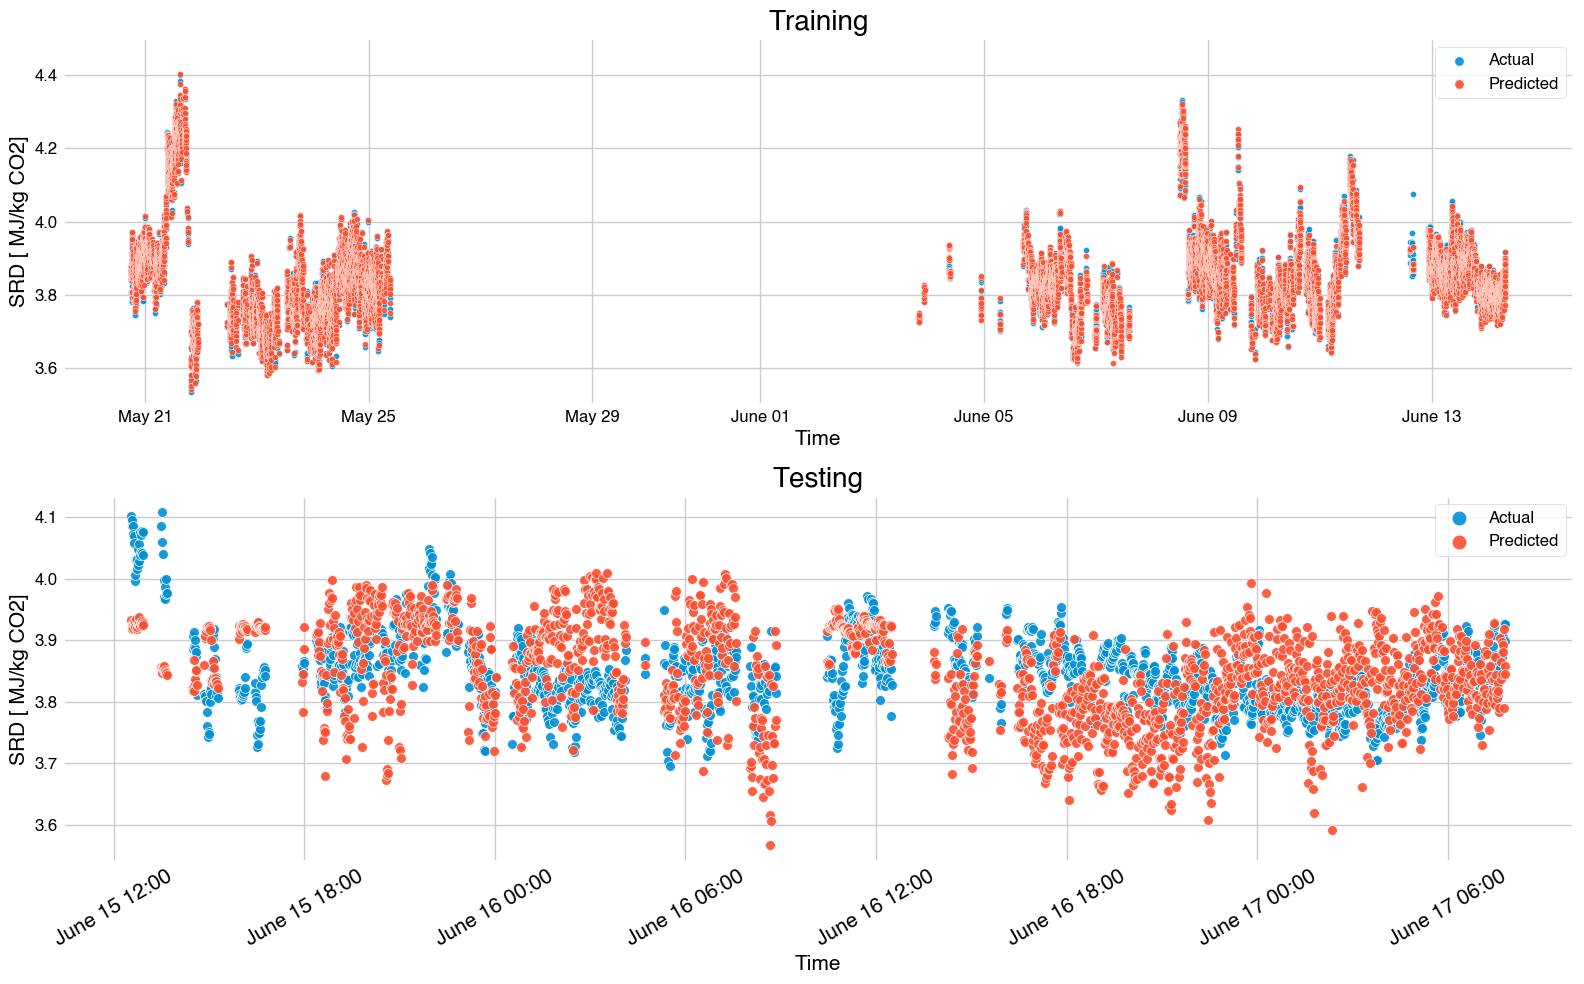

In [240]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_predictions(df_train, df_test, plots_path, overwrite=False):
    fig, ax = plt.subplots(2, figsize=(16, 10))

    sns.scatterplot(ax=ax[0], x=df_train['Time'], y=df_train['Actual'], label='Actual', alpha=0.9, s=20)
    sns.scatterplot(ax=ax[0], x=df_train['Time'], y=df_train['Predicted'], label='Predicted', alpha=0.9, s=20)

    ax[0].set_title('Training', fontsize=20)
    ax[0].set_ylim(3.5, 4.5)
    ax[0].set_xlabel('Time', fontsize=15)
    ax[0].set_ylabel('SRD [ MJ/kg CO2]', fontsize=15)

    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
    ax[0].legend(markerscale=1.5)


    sns.scatterplot(ax=ax[1], x=df_test['Time'], y=df_test['Actual'], label='Actual', alpha=0.9, s=50)
    sns.scatterplot(ax=ax[1], x=df_test['Time'], y=df_test['Predicted'], label='Predicted', alpha=0.9, s=50)

    ax[1].set_title('Testing', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=15)
    ax[1].set_ylabel('SRD [ MJ/kg CO2]', fontsize=15)

    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%B %d %H:00'))
    ax[1].legend(markerscale=1.5)

    plt.xticks(rotation=30, fontsize=15)
    plt.tight_layout()
    utils.save_file(plt.gcf(), plots_path, "Predictions.pdf", 'matplotlib', overwrite)
    plt.show()

loaded_model = keras.models.load_model(best_model_path)
df_train, rmse_train = prediction_df(loaded_model, scaler, X_train, y_train)
df_test, rmse_test = prediction_df(loaded_model, scaler, X_test, y_test)

plot_time_predictions(df_train, df_test, plots_path, overwrite)

In [50]:
def generate_histograms(df):
    x = df['Actual']
    lower_percentile = np.percentile(x, 0.5)
    upper_percentile = np.percentile(x, 99.5)
    mask = (x > lower_percentile) & (x < upper_percentile)
    x_0_5 = x[mask.values].squeeze()
    x_0_5_res = x_0_5 - df['Predicted'][mask.values].squeeze()
    
    q25, q75 = np.percentile(x_0_5, [25, 75])
    bin_width = 2 * (q75 - q25) * len(x_0_5) ** (-1/3)
    bins = round((x_0_5.max() - x_0_5.min()) / bin_width)
    print("Freedman-Diaconis number of bins:", bins)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    ax1.hist(x_0_5, bins=bins, edgecolor='black', alpha=0.8)
    ax1.set_xlabel('Specific Reboiler Duty [MJ/kg CO2]')
    ax1.set_ylabel('Frequency')

    ax2.hist(x_0_5_res, bins=bins, edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Residual [MJ/kg CO2]')
    ax2.set_ylabel('Frequency')

    plt.show()
    
#generate_histograms(df_train)

File Parity_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Parity_plot_ANN.pdf.


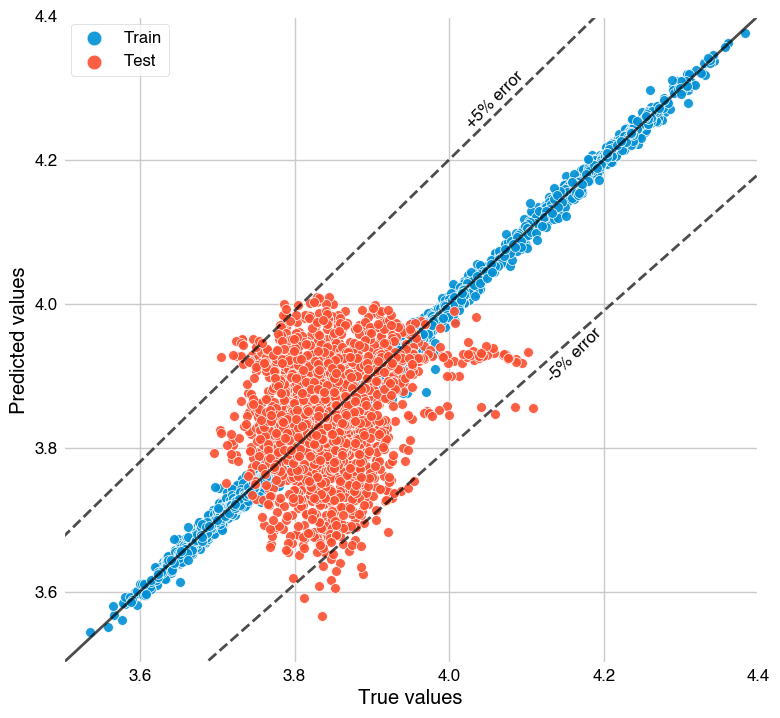

File Residuals_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/Residuals_plot_ANN.pdf.


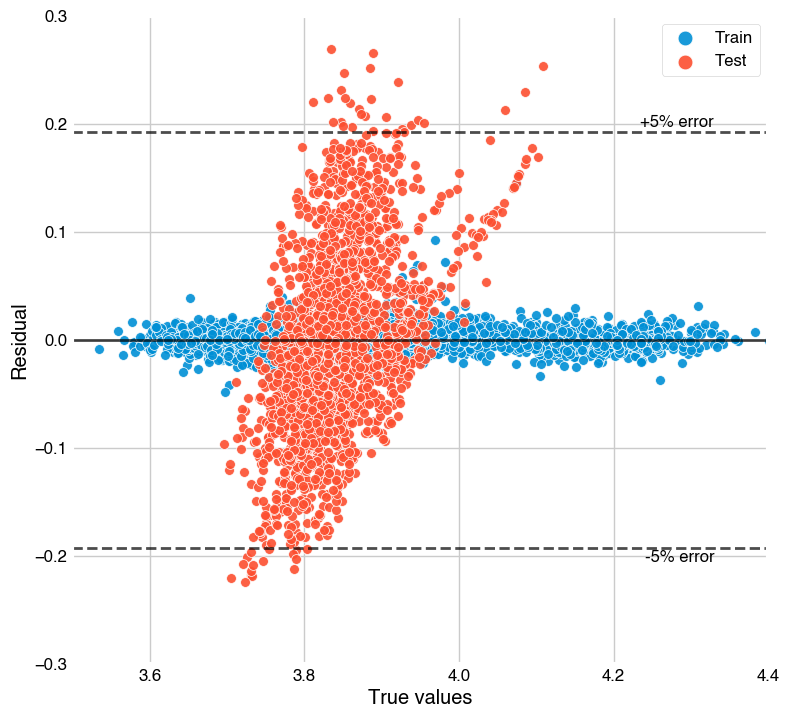

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File ResidualHistogram_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/ResidualHistogram_plot_ANN.pdf.


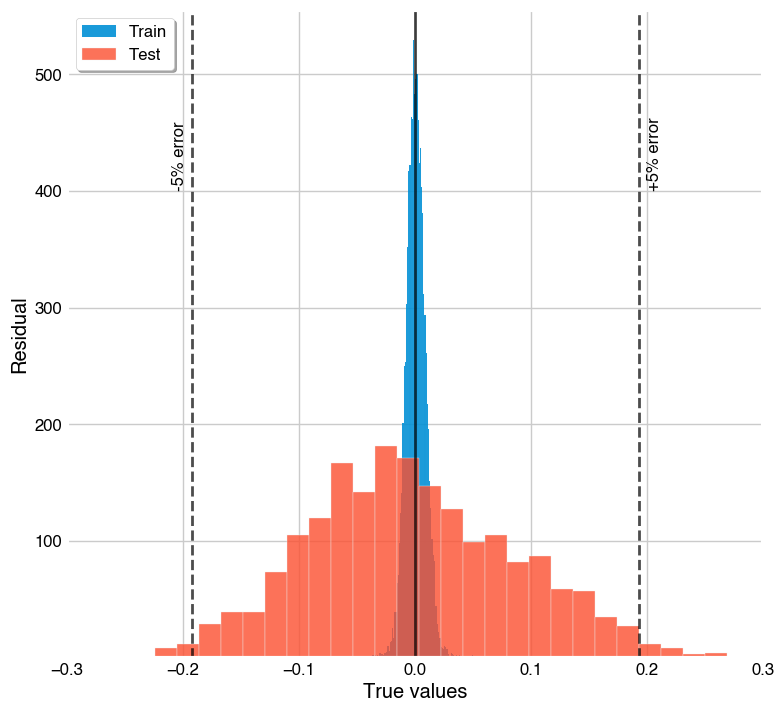

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File KDE_plot_ANN.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/stationary-whole-V3/KDE_plot_ANN.pdf.


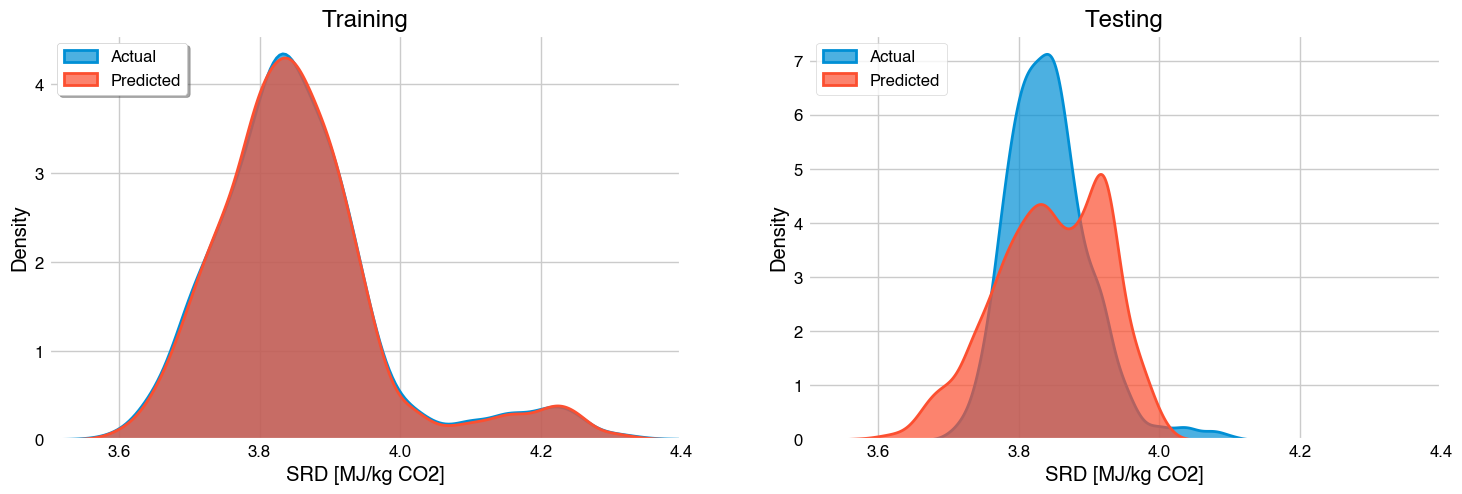

In [181]:
def make_evaluation_plots(plots_path, overwrite, limit, error_line=0.01, res_limit=[-0.3, 0.3], mean=3.85, gridsize=1000):
    parity_plot(plots_path, overwrite, limit, error_line)
    residual_plot(plots_path, overwrite, limit, error_line, res_limit, mean)
    residual_histogram_plot(plots_path, overwrite, error_line, res_limit, mean)
    distribution_plot(plots_path, overwrite, limit, gridsize)
    
def parity_plot(plots_path, overwrite, limit, error_line):
    limit = np.array(limit)
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
    sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

    plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
    plt.plot(limit, (1+error_line)*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
    plt.plot(limit, (1-error_line)*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

    
    if error_line == 0.01:
        plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
        plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

    elif error_line == 0.03:
        plt.text(limit[1]-0.2, 1.05*limit[1]-0.35, '+3% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
        plt.text(limit[1]-0.1, 0.95*limit[1]-0.04, '-3% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)
    
    elif error_line == 0.05:
        plt.text(limit[1]-0.3, 1.05*limit[1]-0.38, '+5% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
        plt.text(limit[1]-0.2, 0.95*limit[1]-0.21, '-5% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)
    

    plt.xlim(limit)
    plt.ylim(limit)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend(markerscale=1.5)

    utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
    plt.show()

def residual_plot(plots_path, overwrite, limit, error_line, res_limit, mean):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
    sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

    plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    plt.axhline(error_line*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
    plt.axhline(-error_line*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

    if error_line == 0.01:
        plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
        plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

    elif error_line == 0.03:
        plt.text(limit[1]-0.07, 0.0305*mean, '+3% error', verticalalignment='bottom', horizontalalignment='right', color='black')
        plt.text(limit[1]-0.07, -0.0305*mean, '-3% error', verticalalignment='top', horizontalalignment='right', color='black')

    elif error_line == 0.05:
        plt.text(limit[1]-0.07, 0.0505*mean, '+5% error', verticalalignment='bottom', horizontalalignment='right', color='black')
        plt.text(limit[1]-0.07, -0.0505*mean, '-5% error', verticalalignment='top', horizontalalignment='right', color='black')

    plt.xlim(limit)
    plt.ylim(res_limit[0], res_limit[1])
    plt.xlabel('True values')
    plt.ylabel('Residual')
    plt.legend(markerscale=1.5)

    utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
    plt.show()

def residual_histogram_plot(plots_path, overwrite, error_line, res_limit, mean):
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    yticks = ax.yaxis.get_major_ticks() 
    yticks[0].label1.set_visible(False)

    sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
    sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

    plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    plt.axvline(error_line*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
    plt.axvline(-error_line*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

    if error_line == 0.01:
        plt.text(0.011*mean, 400, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
        plt.text(-0.01*mean, 400, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

    elif error_line == 0.03:
        plt.text(0.032*mean, 400, '+3% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
        plt.text(-0.031*mean, 400, '-3% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

    elif error_line == 0.05:
        plt.text(0.052*mean, 400, '+5% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
        plt.text(-0.051*mean, 400, '-5% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

    plt.xlim(res_limit)
    plt.xlabel('True values')
    plt.ylabel('Residual')
    plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

    utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
    plt.show()

def distribution_plot(plots_path, overwrite, limit, gridsize):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual', gridsize=gridsize)
    sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted', gridsize=gridsize)
    axs[0].legend(loc='upper left', shadow=True, fancybox=True)
    axs[0].set_xlabel('SRD [MJ/kg CO2]')
    axs[0].set_xlim(limit[0], limit[1])
    axs[0].set_title('Training')

    sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual', gridsize=gridsize)
    sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted', gridsize=gridsize)
    axs[1].legend(loc='upper left')
    axs[1].set_xlim(limit[0], limit[1])
    axs[1].set_xlabel('SRD [MJ/kg CO2]')
    axs[1].set_title('Testing')

    utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
    plt.show()

    
make_evaluation_plots(plots_path, 
                      overwrite=True, 
                      limit=[3.5, 4.4], 
                      error_line=0.05, 
                      res_limit=[-0.3, 0.3], 
                      mean=df['SRD'].mean())

# SFS + ANN

In [ ]:
# read & manipulate data
import keras_tuner as kt
import pandas as pd 
import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# visualisations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# load the dataset
import os
import sys
sys.path.append("../scripts")

# misc
import random as rn

# setting random seeds for libraries to ensure reproducibility
RANDOM_SEED = 420
TRAINING_SAMPLE = 15000
VALIDATE_SIZE = 0.2
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
model_path = '/Users/junxingli/Desktop/master_thesis/models/ann_sfs/' 
feat_path = '19_features'
tuner_path = os.path.join(model_path, feat_path)
file_path = os.path.join(model_path, 'results.pkl')

df = pd.read_pickle(pkl_path)
df = df[df['Status'] == 'Stable']
features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()

def update_dataframe(df, selected_features, training_error, test_error):
    """
    Update the DataFrame with a new row containing information about the selected features, training error, and test error.
    
    Parameters:
    selected_features (list): A list of selected features for this round.
    training_error (float): The training error for this round.
    test_error (float): The test error for this round.
    
    Returns:
    pandas.DataFrame: The updated DataFrame with the new row appended.
    """
    # Create a new row with 0s for all features
    features = df.columns.to_list()[:-2]
    new_row = {feature: 0 for feature in features}
    
    # Update the row based on the selected features for this round
    for feature in selected_features:
        new_row[feature] = 1
        
    # Add training and test error
    new_row['Training Error'] = training_error
    new_row['Test Error'] = test_error
    
    # Append the new row to the DataFrame
    df.loc[len(df.index)] = new_row
    return df

def get_metrics(model, scaler, X, y):
    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))
    rmse = mean_squared_error(y_inv['SRD'], y_pred.flatten(), squared=False)
    r2 = r2_score(y_inv['SRD'], y_pred.flatten())
    
    return rmse, r2

def tune_ANN(df, X_features, proj_path, update=False):
    X = df[X_features]
    y = df[['SRD']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2)
    
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    class MyHyperModel(kt.HyperModel):
        def build(self, hp): 
            hp_learning_rate = hp.Choice('learning_rate', 
                                        values=[1e-1, 1e-2])
                
            model = keras.Sequential()
            model.add(Input(shape=(input_dim,)))
            for i in range(hp.Int('num_layers', 0, 3)):
                model.add(Dense(units=hp.Int('units_' + str(i), 
                                            min_value=5, 
                                            max_value=60, 
                                            step=5),
                                activation='relu'))
            
            model.add(Dense(output_dim, activation='linear'))
            
            # Select optimizer    
            optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
            if optimizer == 'adam':
                model.compile(
                optimizer=keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'SGD':
                model.compile(
                optimizer=keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'rmsprop':
                model.compile(
                optimizer=keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            
            return model

        def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                batch_size=hp.Choice("batch_size", [32, 64, 128]),
                **kwargs,
            )
    
    # Standard scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
    y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))
    
    metric = 'val_mean_squared_error'
    tuner = kt.Hyperband(MyHyperModel(),
                         objective=metric,
                         max_epochs=200,
                         overwrite=False,
                         directory=tuner_path,
                         project_name=proj_path)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor=metric, 
                                                patience=15)

    tuner.search(X_train, y_train, epochs=200, 
                 validation_split=0.25, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    History = best_model.fit(X_train, 
                            y_train, 
                            epochs=800, 
                            callbacks=[tf.keras.callbacks.EarlyStopping(
                                        monitor='mean_squared_error', 
                                        patience=50)
                                        ],
                            validation_split=0)
    
    rmse_train, r2_train = get_metrics(best_model, scaler, X_train, y_train)
    rmse_test, r2_test = get_metrics(best_model, scaler, X_test, y_test)
    
    # Save the model architecture and hyperparameters as txt-file
    summary_dir = os.path.join(tuner_path, proj_path, '00summary')
    os.makedirs(summary_dir, exist_ok=True)
    filename = 'model_summary.txt'
    summary_path = os.path.join(summary_dir, filename)

    with open(summary_path, 'w') as f:
        txt = f"""Training error: {rmse_train}
        R2 score: {r2_train}
        -------------------------------------
        Test error: {rmse_test}
        R2 score: {r2_test}
        -------------------------------------
        Parameters: {X_features}
        """
        f.write(str(txt))
        best_model.summary(print_fn=lambda x: f.write(x + '\n'))
        
        if hasattr(best_hps, 'values'):
            for param, value in best_hps.values.items():
                f.write(f"{param}: {value}\n")
        else:
            f.write(str(best_hps))
            
    # Save the model feautures and errors to a DataFrame
    if update:
        if not os.path.exists(file_path):
            features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()
            sfs_df = pd.DataFrame(columns=features + ['Training Error', 'Test Error'])
            sfs_df.to_pickle(file_path)
        
        sfs_df = pd.read_pickle(file_path)    
        sfs_df = update_dataframe(sfs_df, X_features, rmse_train, rmse_test)
        sfs_df.to_pickle(file_path)
    return best_model

In [ ]:
#optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1']
optimal_features = features[:-1]
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    tune_ANN(df, optimal_features + [feature], proj_path, update=True)

In [ ]:
def find_optimal_features(df, num_features, method='train'):
    """
    Identifies columns with a value of 1 in the row with the minimum training or test error,
    after filtering rows based on the sum of their feature values being equal to num_features.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - num_features (int): The number of features that must sum to 1 to consider a row.
    - method (str): The error type to minimize ('train' or 'test').
    
    Returns:
    - list: A list of optimal feature column names.
    """

    df_filtered = df.drop(['Training Error', 'Test Error'], axis=1)
    df_filtered['Sum'] = df_filtered.sum(axis=1)
    df_features = df_filtered[df_filtered['Sum'] == num_features]
    
    # Check if there are any rows meeting the criteria
    if df_features.empty:
        raise ValueError("No rows with the specified number of features found.")
    
    # Find indexes of rows with minimum error within the filtered DataFrame
    idx_train = df_features.join(df['Training Error'])['Training Error'].idxmin()
    idx_test = df_features.join(df['Test Error'])['Test Error'].idxmin()
    if idx_train != idx_test:
        warnings.warn("Best training and best test are not the same!")
    
    # Select the row based on the specified method
    if method == 'train':
        optimal_row = df.loc[idx_train]
    elif method == 'test':
        optimal_row = df.loc[idx_test]
    else:
        raise ValueError("Method must be either 'train' or 'test'")
    
    print(f"Optimal row: {optimal_row}")
    
    # Identify columns with a value of 1 in the optimal row
    optimal_features = optimal_row.index[optimal_row.eq(1)].tolist()
    
    return optimal_features

sfs_df = pd.read_pickle(file_path)
print(find_optimal_features(sfs_df, 19, 'train'))
print(find_optimal_features(sfs_df, 19, 'test'))
#sfs_df

### Best 1 feature

In [ ]:
optimal_features = []
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'T2':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, scaler, X_train[['Time', 'T2']], y_train)
df_test, rmse_test = prediction_df(model, scaler, X_test[['Time', 'T2']], y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.3, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 2 features

In [ ]:
optimal_features = ['T2']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'D8':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['D8']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['D8']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.3, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 3 features

In [ ]:
optimal_features = ['T2', 'D8']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'B12':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['B12']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['B12']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 4 features

In [ ]:
optimal_features = ['T2', 'D8', 'B12']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'T3':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['T3']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['T3']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 5 features

In [ ]:
optimal_features = ['T2', 'D8', 'B12', 'T3']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'T10':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['T10']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['T10']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 6 features

In [ ]:
optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'D1':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['D1']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['D1']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 7 features

In [ ]:
optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == 'T1':
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+optimal_features + ['T1']], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+optimal_features + ['T1']], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

### Best 19 features

In [ ]:
optimal_features = features[:-1]
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train = prediction_df(model, 
                                     scaler, 
                                     X_train[['Time']+features], 
                                     y_train)
df_test, rmse_test = prediction_df(model, 
                                   scaler,
                                   X_test[['Time']+features], 
                                   y_test)

# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Parity_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.2, 0.3)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

#utils.save_file(plt.gcf(), plots_path, "Residuals_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left', shadow=True, fancybox=True)

#utils.save_file(plt.gcf(), plots_path, "ResidualHistogram_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left', shadow=True, fancybox=True)
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

#utils.save_file(plt.gcf(), plots_path, "KDE_plot_ANN.pdf", 'matplotlib', overwrite)
plt.show()